In [8]:
import os
import os.path as osp
import json
import numpy as np

import skimage.io
import matplotlib.pyplot as plt

from utils import transform_coordinates, transform_coordinates_back, adjust_coordinates
from utils import crop, normalize_pic, non_lin_transform, transform_label_coordinates
from utils import pill_cropping_pars, crop_pills_and_save_coordinates, crop_pills_and_save_stats

In [5]:
from random import shuffle

In [3]:
path = '../public_data'

In [4]:
label_names = [file for file in os.listdir(path) if file.endswith('.json')]
feature_names = [name.replace('.json', '.tiff') for name in label_names]

In [6]:
# Method predict in model.py
dics = []
_predictions = {}
predictions = {}
for idx, val in enumerate(feature_names):
    if idx==3:
        # Consider a limited number of samples
        break
    predictions['file'] = val
    img = skimage.io.imread(osp.join(path, feature_names[idx]))
    with open(osp.join(path, label_names[idx])) as f:
        d = json.load(f)
    # Crop a bliter pack
    img_cpd, M, was_vertical = crop(img)
    
    img_norm = normalize_pic(img_cpd)
    img_nl = non_lin_transform(img_norm)
    _coorm, _coorp = crop_pills_and_save_coordinates(img_nl)
    _predictions['missing'] = transform_coordinates_back(list(zip(*_coorm)), M, was_vertical)
    _predictions['present'] = transform_coordinates_back(list(zip(*_coorp)), M, was_vertical)
    predictions['coordinates'] = _predictions.copy()
    predictions['missing_pills'] = len(_coorm)
    predictions['present_pills'] = len(_coorp)
    dics.append(predictions.copy())

In [9]:
# Collect statistics e.g. to see how does the histogram look like
_miss_px_all, _pres_px_all = [], []
_miss_all, _pres_all = [], []
for idx, val in enumerate(feature_names):
    if idx==3:
        # Consider a limited number of samples
        break
    img = skimage.io.imread(osp.join(path, feature_names[idx]))
    with open(osp.join(path, label_names[idx])) as f:
        d = json.load(f)
    img_cpd, M, was_vertical = crop(img)
    # Statistic collection
    # Obtain the labels and transform them
    coorm_t, coorp_t = transform_label_coordinates(d['coordinates']['missing'], d['coordinates']['present'], M, was_vertical)
    __miss_all, __pres_all = crop_pills_and_save_stats(img_cpd, coorp_t, plot=False)
    if __miss_all.all():
        _miss_all.append(__miss_all)
    if __pres_all.all():
        _pres_all.append(__pres_all)
    #true_coorp = transform_coordinates_back(coorp_t, M, was_vertical) 

In [10]:
miss_all = np.concatenate(_miss_all, axis=-1)
shuffle(miss_all)
pres_all = np.concatenate(_pres_all, axis=-1)
shuffle(pres_all)
min_val = min(miss_all.shape[0], pres_all.shape[0])
#miss_all = miss_all[:min_val]
#pres_all = pres_all[:min_val]

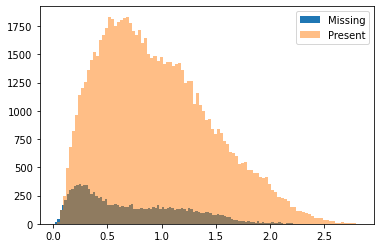

In [11]:
# If we can find a nonlinear transformation that separates missing/present coodrinates quite well - we will definitelly 
# succeed. For now, the best one I found is to bring the normalized pixel values to the power of 3 and then take the mean 
# of the cropped pill (see below). Setting a threshold to around 0.5 gave us around 70 % of accuracy
plt.hist(miss_all, bins = 100, label='Missing')
plt.hist(pres_all, bins = 100, label='Present', alpha=0.5)
plt.legend()
#plt.title('$mean((CropPixel Intensities)^3)$')
#plt.savefig('../status/pixel_intensities.jpg')
plt.show()

### Compare our predictions with the ground truth

Text(0.5, 1.0, 'a4f48bc93700129314acd7e55e34e0e6.tiff')

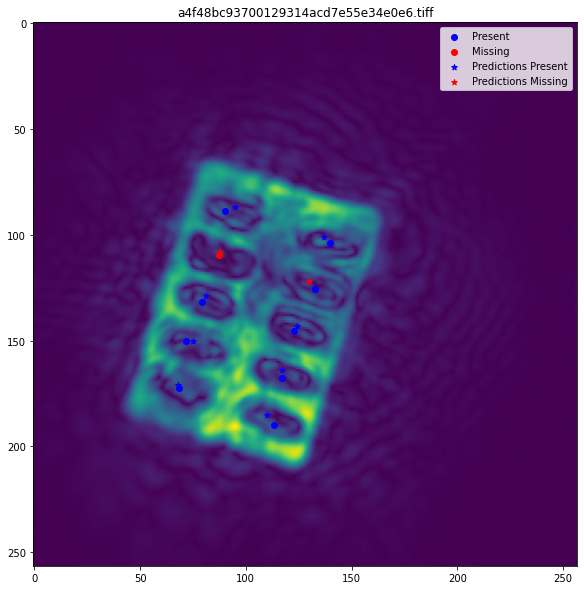

In [12]:
# Ground truth
plt.figure(figsize=(30, 10))
plt.imshow(img[..., 0])
plt.scatter(np.array(d['coordinates']['present'])[:, 0], 257-np.array(d['coordinates']['present'])[:, 1], color='b',
            label='Present')
plt.scatter(np.array(d['coordinates']['missing'])[:, 0], 257-np.array(d['coordinates']['missing'])[:, 1], color='r',
            label='Missing')
# Predicitons
plt.scatter(np.array(predictions['coordinates']['present'])[:, 0], 257 - np.array(predictions['coordinates']['present'])[:, 1], marker='*', color='b', label='Predictions Present')
plt.scatter(np.array(predictions['coordinates']['missing'])[:, 0], 257 - np.array(predictions['coordinates']['missing'])[:, 1], marker='*', color='r', label='Predictions Missing')
plt.legend(bbox_to_anchor=(1, 1))
plt.title(val)
#plt.savefig('../status/locAcc.jpg', bbox_inches='tight')